# Deep Deterministic Policy Gradient: DDPG
This notebook is an implementation of the DDPG algorithm to solve the Reacher environment. You can find
an explanation of DDPG in this [paper](https://arxiv.org/abs/1509.02971)
and an explanation of the Reacher enviornment [here](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md).

## 1. Import all necessary packages
If you have any trouble importing these packages make sure you check the README file and have all the necessary dependencies.

In [1]:
from unityagents import UnityEnvironment
from collections import deque
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from agents import DDPG

PATH = "C:\Dev\Python\RL\\Udacity_Continuous_Control"


## 2. Setup the Environment
Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.
**Note:** `file_name` parameter must match the location of the Unity environment that you downloaded.

In [2]:
env = UnityEnvironment(file_name='C:\Dev\Python\RL\\Udacity_Continuous_Control\Reacher_Windows_x86_64_multiple\Reacher.exe', no_graphics=True)
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment and get env info to setup Agent
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 3. Setup and Train the Agent
This section contains a function for training the agent. If you do not want to train the agent and only wish to see the result of training and view the agent then set
`train = false` or skip this section.

In [3]:
ddpg_agent = DDPG(state_size=state_size, action_size=action_size, num_agents=len(env_info.agents), random_seed = 2)
train = True

def train_agent(agent: DDPG, num_episodes= 200, max_time = 1000, print_every = 10):
    #--------- Set Everything up --------#
    mean_scores = []
    scores_deque = deque(maxlen=print_every)
    epsilon = 1
    epsilon_decay = 0.99
    epsilon_min = 0.005

    #-------- Simulation Loop --------#
    for episode_num in range(1,num_episodes+1):
        # Reset everything
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(agent.num_agents)
        agent.reset()
        # Run the episode
        for t in range(max_time):
            actions = agent.act(states, epsilon)
            env_info = env.step(actions)[brain_name]
            next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            scores += rewards
            states = next_states
            if np.any(dones):
                break

        #-------- Episode Finished ---------#
        epsilon *= epsilon_decay
        epsilon = max(epsilon, epsilon_min)
        mean_scores.append(np.mean(scores))
        scores_deque.append(np.mean(scores))
        if episode_num % print_every == 0:
            print(f'Episode: {episode_num} \tAverage Score: {round(np.mean(scores_deque),2)}')
            torch.save(agent.actor_local.state_dict(), f'{PATH}\checkpoints\{agent}_Actor_Multiple.pth')
            torch.save(agent.critic_local.state_dict(), f'{PATH}\checkpoints\{agent}_Critic_Multiple.pth')

    #-------- All Episodes finished Save parameters and scores --------#
    torch.save(agent.actor_local.state_dict(), f'{PATH}\checkpoints\{agent}_Actor_Multiple.pth')
    torch.save(agent.critic_local.state_dict(), f'{PATH}\checkpoints\{agent}_Critic_Multiple.pth')
    f = open(f'{PATH}\scores\{agent}_Multiple_Scores.txt', 'w')
    scores_string = "\n".join([str(score) for score in mean_scores])
    f.write(scores_string)
    f.close()
    return mean_scores


if train:
    train_agent(ddpg_agent)


Episode: 1 	 Score: 0.16599999628961087
Episode: 2 	 Score: 0.4734999894164503
Episode: 3 	 Score: 0.2794999937526882
Episode: 4 	 Score: 0.3259999927133322
Episode: 5 	 Score: 0.27299999389797447
Episode: 6 	 Score: 0.2389999946579337
Episode: 7 	 Score: 0.17999999597668648
Episode: 8 	 Score: 0.1304999970830977
Episode: 9 	 Score: 0.07649999829009176
Episode: 10 	 Score: 0.22349999500438572
Episode: 10 	Average Score: 0.24
Episode: 11 	 Score: 0.5789999870583415
Episode: 12 	 Score: 0.82099998164922
Episode: 13 	 Score: 0.46999998949468136
Episode: 14 	 Score: 0.5594999874942005
Episode: 15 	 Score: 0.7674999828450382
Episode: 16 	 Score: 0.6829999847337603
Episode: 17 	 Score: 0.2834999936632812
Episode: 18 	 Score: 0.8389999812468887
Episode: 19 	 Score: 0.7999999821186066
Episode: 20 	 Score: 1.3454999699257315
Episode: 20 	Average Score: 0.71
Episode: 21 	 Score: 1.5369999656453728
Episode: 22 	 Score: 1.8184999593533575
Episode: 23 	 Score: 1.9419999565929174
Episode: 24 	 Score

## 4. View the Results of Training

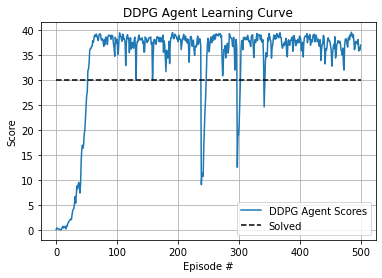

In [4]:
def graph_results(filename, save_graph = True):
    """ Graph results from training an Agent

    :param filename: file to get scores from
    """
    # Read in results from file
    with open(filename) as f:
        scores = [round(float(score),2) for score in f.read().splitlines()]

    # Graph results
    fig, ax = plt.subplots()
    ax.set(xlabel="Episode #", ylabel="Score", title="DDPG Agent Learning Curve")
    ax.grid()
    ax.plot(np.arange(len(scores)), scores, label="DDPG Agent Scores")
    ax.plot(np.arange(len(scores)), np.ones(len(scores))*30, color="black", linestyle="dashed", label="Solved")
    ax.legend()
    # Save graph results
    if save_graph:
        fig.savefig(f'{PATH}\images\DDPG_Agent_Multiple.png')
    plt.show()

graph_results(f'{PATH}\scores\DDPG_Agent_Multiple_Scores.txt')




## 5. Watch the Trained Agent